In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import struct
from array import array
from os.path import join
from tqdm import trange

In [15]:

# Copy pasta data loader
class DataLoader():
    def __init__(self):
        input_path = './imgs'
        self.training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
        self.training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
        self.test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
        self.test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img
        
        return images, labels

    def load(self, split):
        if split == 'train':
            Y, X = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)    
        else:
            Y, X = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        Y = np.array(Y).reshape((-1, 28 * 28))
        Y = torch.tensor(Y, dtype=torch.float32) / 255 # normalize vals
        X = torch.tensor(np.eye(10)[X], dtype=torch.float32) # one hot encode
        return X, Y


In [18]:
# Data
loader = DataLoader()
Xtr, Ytr = loader.load('train')
Xval, Yval = loader.load('val')

In [19]:
# Hyperparams
iters = 1000
batch_size = 64
lr = 1e-3

In [42]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(10, 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 784)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x
    
    def train(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr)
        for i in (t := trange(iters)):
            batch = np.random.randint(0, Xtr.shape[0], size=(batch_size))
            Xb = Xtr[batch]
            Yb = Ytr[batch]
            logits = self(Xb)
            loss = F.cross_entropy(logits, Yb)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            t.set_description(f"loss: {loss.item():.2f}")
        return logits
    
    def generate(self, nums):
        # If nums is a single number, convert it to a list for consistency
        if isinstance(nums, int):
            nums = [nums]

        logits_list = []
        for num in nums:
            one_hot = np.eye(10)[num]
            x = torch.tensor(one_hot).unsqueeze(0).float()
            logits = self(x)
            logits_list.append(logits)

        # Concatenate all logits along the first dimension
        logits_all = torch.cat(logits_list, dim=0)
        self.visualize(logits_all)
        
    def visualize(self, logits):
        # If logits is 1-dimensional, reshape it to 2-dimensional for consistency
        if len(logits.shape) == 1:
            logits = logits.reshape(1, -1)

        # Determine the grid size based on the number of images
        grid_size = int(np.ceil(np.sqrt(logits.shape[0])))
        
        fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
        
        # Ensure axs is always a 2D array
        if grid_size == 1:
            axs = np.array([[axs]])

        for i, logit in enumerate(logits):
            y = logit.reshape(28, 28).detach().numpy()
            y = y * 255
            ax = axs[i // grid_size, i % grid_size]
            ax.imshow(y)
            ax.axis('off')
        
        # Remove unused subplots
        for i in range(logits.shape[0], grid_size*grid_size):
            fig.delaxes(axs.flatten()[i])
        
        plt.tight_layout()
        plt.show()


loss: 608.73: 100%|██████████| 1000/1000 [00:01<00:00, 504.66it/s]


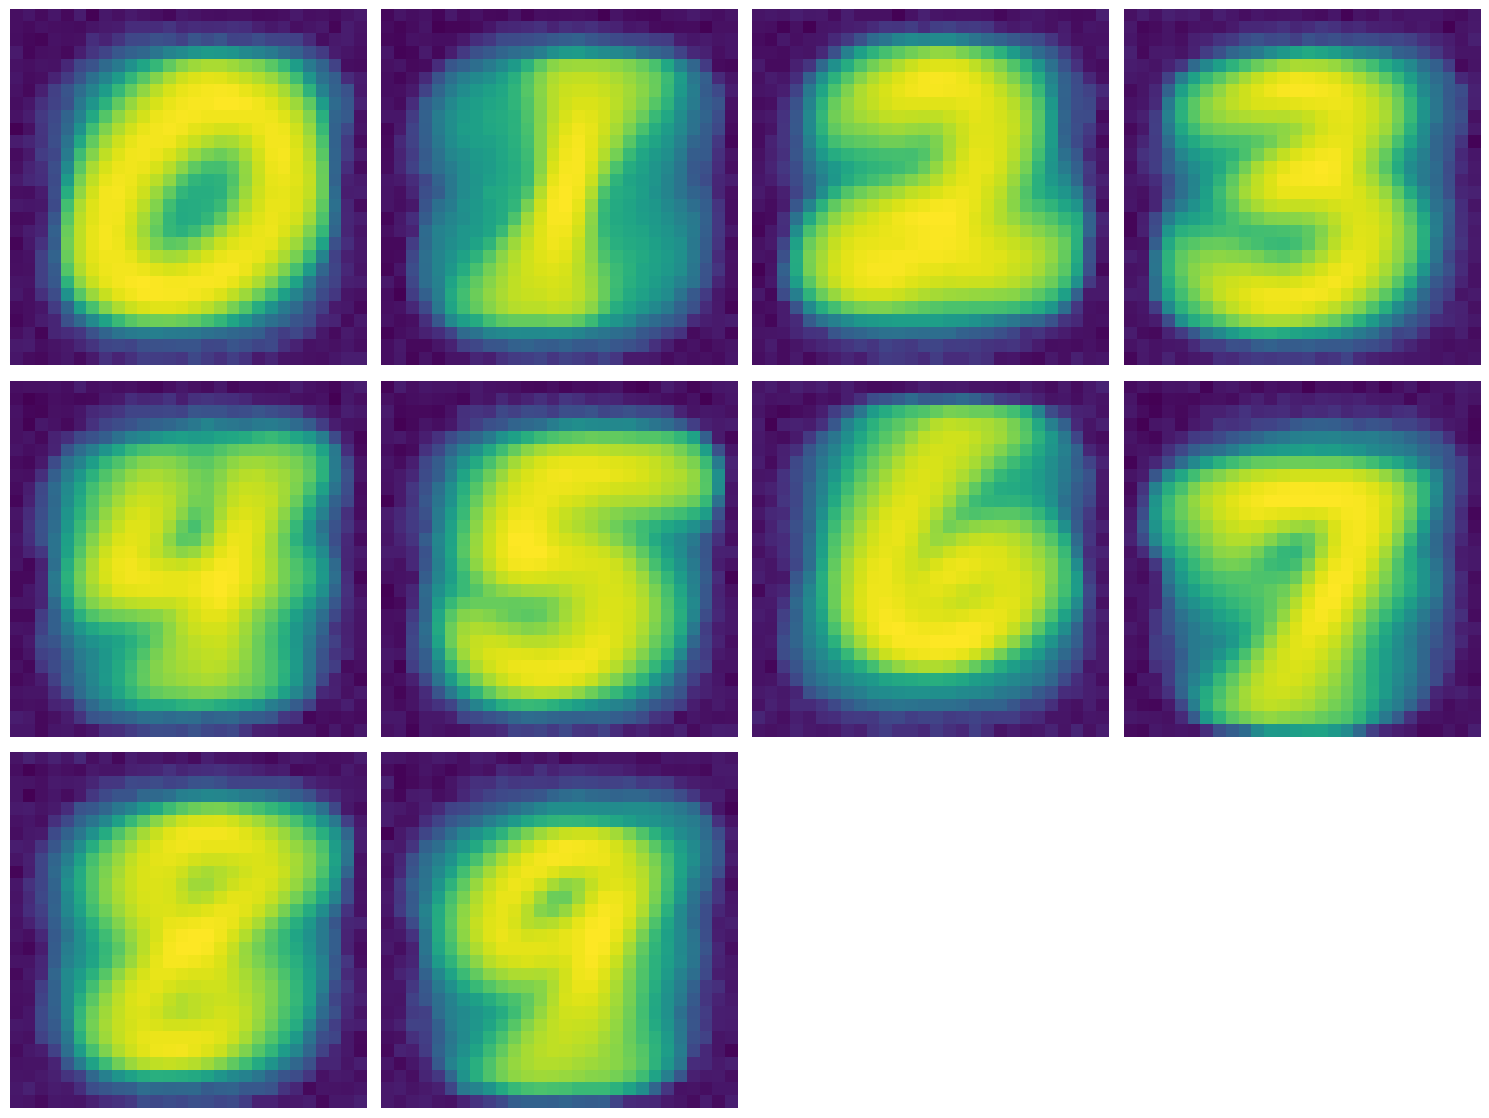

In [47]:
model = Model()
model.train()
model.generate(list(range(10)))